In [11]:
import sys
import json
import numpy as np
from statsmodels.discrete.discrete_model import Logit
from collections import defaultdict, Counter
import random
from sklearn.linear_model import LogisticRegression, ElasticNet,Lasso
import matplotlib.pyplot as plt
from sklearn import metrics
import cvxpy as cp
import csv
from scipy.stats import pearsonr, binom_test

In [12]:
deletion_dir = '../phased_ihart.ms2_quads_del'
ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'

chroms = [str(x) for x in range(1, 23)] #+ ['X']
#chroms = ['10']
#deletion_dir2 = '../deletions_ssc'
#ped_file2 = '../data/ssc.ped'

deletion_share_cutoff=0.5

In [13]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)

child_id_to_sex = dict()
child_id_to_affected = dict()
family_to_people = defaultdict(set)
child_id_to_dataset = dict()

def load_ped(ped_file):
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex
                family_to_people[fam_id].add(child_id)
                child_id_to_dataset[child_id] = ped_file
load_ped(ped_file)
#load_ped(ped_file2)

child_id_to_famsize = dict()
for people in family_to_people.values():
    for child in people:
        child_id_to_famsize[child] = len(people)

print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 2635


In [14]:
print(Counter([sum([child_id_to_affected[x]=='2' for x in v]) for v in family_to_people.values()]))

Counter({2: 1336, 1: 982, 0: 73})


In [37]:
children = sorted(set(sum([[(f, x) for x in v] for f, v in family_to_people.items()], [])))

In [38]:
# pull MDS
#mds_file = '../../SBSE/mds/1kg+v34+ssc+psp-mds.mds'
#sample_to_mds = dict()
#with open(mds_file, 'r') as f:
#    next(f) # skip header
#    for line in f:
#        pieces = line.strip().split()
#        sample_id = pieces[1]
#        if sample_id.startswith('NYGC'):
#            # unfortunately, the MDS has slightly different sample ids for the PSP samples compared to the ped/vcf
#            sample_id = sample_id[5:]
#        elif sample_id.startswith('AFR') or sample_id.startswith('AMR') or sample_id.startswith('EAS') or sample_id.startswith('EUR') or sample_id.startswith('SAS'):
#            sample_id = sample_id[8:]
#
#        sample_to_mds[sample_id] = [float(pieces[3]), float(pieces[4]), float(pieces[5]), float(pieces[6])]#
#
 #       
#children = [x for x in children if x in sample_to_mds]
#M = np.array([sample_to_mds[x] for x in children])
#print(M.shape)

In [40]:
child_to_index = dict([(x, i) for i, x in enumerate(children)])


3654 1128 0 0


In [41]:
with open('%s/deletions.json' % deletion_dir, 'r') as f:
    deletions = json.load(f)
    familes = set([x['family'] for x in deletions])
    
# load first deletion_dir collections
with open('%s/collections.json' % deletion_dir, 'r') as f:
    collections = json.load(f)
    collections = [c for c in collections if len(c['matches'])>5]
    print(len(collections))


34207


In [42]:
print(len(deletions))
print(len(collections))

471339
34207


In [81]:
Xs_mat = []
Xs_pat = []
Zs_mat = []
Zs_pat = []
all_deletions = []
parents = set()

X_mat = np.zeros((len(children), len(collections)), dtype=np.int8)
X_pat = np.zeros((len(children), len(collections)), dtype=np.int8)
all_deletions.extend([(c['deletion']['chrom'], c['deletion']['start_pos'], c['deletion']['end_pos'])  for c in collections])

for i, c in enumerate(collections):
    for m in c['matches']:
        if m['is_mat']:
            for child in m['trans']:
                if (m['family'], child) in child_to_index:
                    X_mat[child_to_index[(m['family'], child)], i] = 1
        else:
            for child in m['trans']:
                if (m['family'], child) in child_to_index:
                    X_pat[child_to_index[(m['family'], child)], i] = 1
        parents.add(m['father'])
        parents.add(m['mother'])
                
X = X_mat + X_pat
print(X.shape)

(4782, 34207)


In [82]:
print(np.sum(X_mat))

4043136


In [83]:
child_to_indices = defaultdict(list)
for i, (f, child) in enumerate(children):
    child_to_indices[child].append(i)

In [84]:
aggchildren = sorted(child_to_indices.keys())
aggchild_to_index = dict([(x, i) for i, x in enumerate(aggchildren)])

In [85]:
print(np.median(X_mat[child_to_indices[child], :], axis=0))

[0. 0. 0. ... 0. 0. 0.]


In [86]:
child_X_mat, child_X_pat = np.zeros((len(aggchildren), X_mat.shape[1]), dtype=np.int8), np.zeros((len(aggchildren), X_mat.shape[1]), dtype=np.int8)

for i, child in enumerate(aggchildren):
    child_X_mat[i, :] = np.median(X_mat[child_to_indices[child], :], axis=0)
    child_X_pat[i, :] = np.median(X_pat[child_to_indices[child], :], axis=0)

In [87]:
X = child_X_mat + child_X_pat


In [88]:

is_parent = np.array([x in parents for x in aggchildren])
is_male = np.array([child_id_to_sex[x]=='1' for x in aggchildren])
y = np.array([child_id_to_affected[x]=='2' for x in aggchildren])
is_ihart = np.array([child_id_to_dataset[x] == ped_file for x in aggchildren])
print(np.sum(y[is_ihart]), np.sum(~y[is_ihart]), np.sum(y[~is_ihart]), np.sum(~y[~is_ihart]))

2144 491 0 0


In [89]:
has_data = np.zeros((X.shape[0],), dtype=bool)

with open('%s/individuals.json' % deletion_dir, 'r') as f:
    individuals = json.load(f)
    for ind in individuals:
        if ind in aggchild_to_index:
            has_data[aggchild_to_index[ind]] = True
            
has_data = has_data & ~is_parent

print(np.sum(has_data))


2267


In [90]:
lengths = np.array([x[2]-x[1] for x in all_deletions])


In [91]:
## remove centromeres
#with open('../data/cytoBand.txt') as f:
#    for line in f:
#        pieces = line.strip().split('\t')
#        if pieces[4] == 'acen':
#            ch = pieces[0][3:]
#            start_pos, end_pos = int(pieces[1]), int(pieces[2])
#            for i, d in enumerate(all_deletions):
#                if d[0] == ch:
#                    overlap = min(d[2], end_pos) - max(d[1], start_pos)
#                    if overlap>0:
#                        lengths[i] = 0

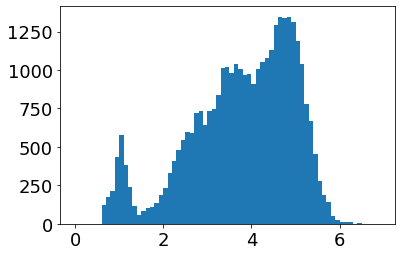

In [92]:
plt.hist(np.log10(lengths), bins=np.arange(0, 7, 0.1))
plt.show()

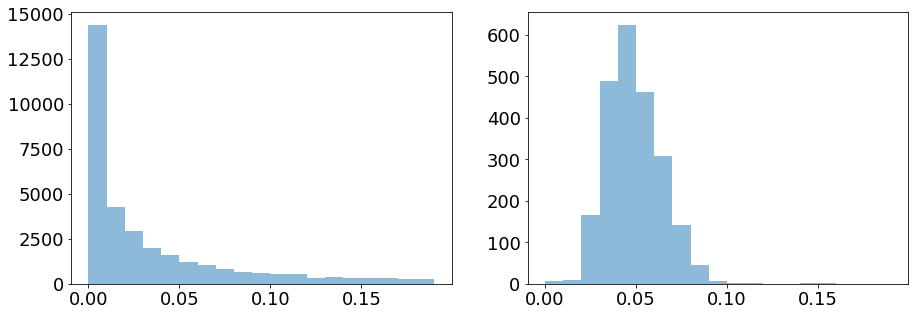

In [93]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(np.sum(X[is_ihart & has_data, :], axis=0)/X.shape[0], bins=np.arange(0, 0.2, 0.01), alpha=0.5)
#plt.hist(np.sum(Z[is_ihart & has_data, :], axis=0)/X.shape[0], bins=np.arange(0, 0.2, 0.01), alpha=0.5)
plt.subplot(1, 2, 2)
plt.hist(np.sum(X[is_ihart & has_data, :], axis=1)/X.shape[1], bins=np.arange(0, 0.2, 0.01), alpha=0.5)
#plt.hist(np.sum(Z[is_ihart & has_data, :], axis=1)/X.shape[1], bins=np.arange(0, 0.2, 0.01), alpha=0.5)
plt.show()

# Model

In [94]:
test_families = random.sample(family_to_people.keys(), int(np.floor(len(family_to_people)*0.2)))

In [95]:
test_children = set(sum([list(family_to_people[fam_id]) for fam_id in test_families], []))
test_indices = np.array([x in test_children for x in aggchildren])
print(np.sum(test_indices), np.sum(~test_indices))

834 1801


In [96]:
print(np.sum(y[test_indices]), np.sum(~y[test_indices]), np.sum(y[test_indices & ~is_ihart]))

644 190 0


In [120]:
#has_homalt = np.any((X+Z)==2, axis=0)
##
#X_bin = np.zeros((X.shape[0], X.shape[1]+np.sum(has_homalt)))
#X_bin[:, :X.shape[1]] = (X+Z)>0
#X_bin[:, X.shape[1]:] = (X+Z)[:, has_homalt]==2
#print(X_bin.shape)

#has_homalt = np.any(X==2, axis=0)

#X_bin = np.zeros((X.shape[0], X.shape[1]+np.sum(has_homalt)))
#X_bin[:, :X.shape[1]] = X>0
#X_bin[:, X.shape[1]:] = X[:, has_homalt]==2
#print(X_bin.shape)

X_bin = X>0

In [135]:
#model = LogisticRegression(penalty='elasticnet', solver='saga', C=0.05, l1_ratio=0.9)
X_full = np.hstack((is_male[:, np.newaxis],
                              ~is_male[:, np.newaxis], 
                               X_bin[:, :],
                                #np.ones((X_bin.shape[0], 1))
                    ))

model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
result = model.fit(X_full[~test_indices & is_ihart & has_data & ~is_parent, :], y[~test_indices & is_ihart & has_data & ~is_parent])
coeffs = result.coef_.flatten()[2:]

predict = model.predict_proba(X_full)[:, 1]
print(np.sum(~np.isclose(coeffs, 0)))

72


In [136]:
## nonnegative
#indices = ~np.isclose(result.coef_.flatten(), 0)
#indices[:2] = True
#n = np.sum(indices)
#print(indices)
#
#lambd = 0.05
#beta = cp.Variable(n)
#log_likelihood = cp.sum(
#    cp.multiply(y[~test_indices & is_ihart & has_data & ~is_parent], X_full[np.ix_(~test_indices & is_ihart & has_data & ~is_parent, indices)] @ beta) - cp.logistic(X_full[np.ix_(~test_indices & is_ihart & has_data & ~is_parent, indices)] @ beta)
#)
#problem = cp.Problem(cp.Maximize(log_likelihood/n - lambd * cp.norm(beta[2:], 1)), [beta[2:]>=0])
#problem.solve()#
#
#predict = 1/(1+np.exp((-X_full[:, indices] @ beta).value))
#coeffs = beta.value[2:]
#
#print(np.sum(~np.isclose(beta.value, 0)))

In [137]:
#model = LogisticRegression(penalty='elasticnet', solver='saga', C=0.05, l1_ratio=0.9)
simple_model = LogisticRegression(penalty='none', solver='newton-cg')
simple_result = simple_model.fit(np.hstack((is_male[~test_indices & is_ihart & has_data & ~is_parent, np.newaxis],
                                 ~is_male[~test_indices & is_ihart & has_data & ~is_parent, np.newaxis])), 
                   y[~test_indices & is_ihart & has_data & ~is_parent])
simple_predict = simple_model.predict_proba(np.hstack((is_male[:, np.newaxis], ~is_male[:, np.newaxis])))[:, 1]

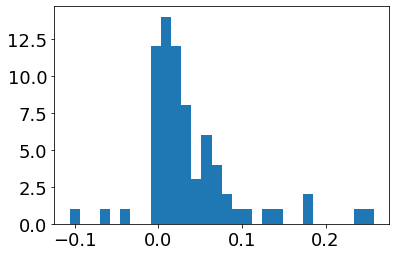

In [138]:
plt.hist(coeffs[~np.isclose(coeffs, 0)], bins=30)
plt.show()

0.6297684351576568
M 0.5281832767826613
F 0.47379629629629627
simple 0.6215139650768393


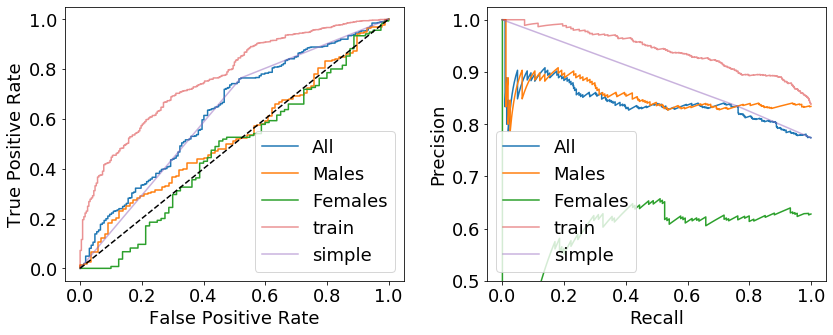

In [139]:
plt.rcParams.update({'font.size': 18})




plt.figure(figsize=(12, 5))

ax = plt.subplot(1, 2, 1)
train_fpr, train_tpr, _ = metrics.roc_curve(y[~test_indices & is_ihart & has_data], predict[~test_indices & is_ihart & has_data])

test_fpr, test_tpr, _ = metrics.roc_curve(y[test_indices & is_ihart & has_data], predict[test_indices & is_ihart & has_data])
plt.plot(test_fpr, test_tpr, label='All')#, color='#009668')
print(metrics.auc(test_fpr, test_tpr))

test_fpr, test_tpr, _ = metrics.roc_curve(y[test_indices & is_ihart & has_data & is_male], predict[test_indices & is_ihart & has_data & is_male])
plt.plot(test_fpr, test_tpr, label='Males')
print('M', metrics.auc(test_fpr, test_tpr))

test_fpr, test_tpr, _ = metrics.roc_curve(y[test_indices & is_ihart & has_data & ~is_male], predict[test_indices & is_ihart & has_data & ~is_male])
plt.plot(test_fpr, test_tpr, label='Females')
print('F', metrics.auc(test_fpr, test_tpr))

plt.plot(train_fpr, train_tpr, label='train', alpha=0.5)

simple_test_fpr, simple_test_tpr, _ = metrics.roc_curve(y[test_indices & is_ihart & has_data], simple_predict[test_indices & is_ihart & has_data])
plt.plot(simple_test_fpr, simple_test_tpr, label='simple', alpha=0.5)
print('simple', metrics.auc(simple_test_fpr, simple_test_tpr))

#test_fpr, test_tpr, _ = metrics.roc_curve(y[test_indices & is_ihart & has_data & ~is_parent], predict[test_indices & is_ihart & has_data & ~is_parent])
#plt.plot(test_fpr, test_tpr, label='test child')
#print(metrics.auc(test_fpr, test_tpr))

#test_fpr, test_tpr, _ = metrics.roc_curve(y[test_indices & is_ihart & has_data & is_parent], predict[test_indices & is_ihart & has_data & is_parent])
#plt.plot(test_fpr, test_tpr, label='test parent')
#print(metrics.auc(test_fpr, test_tpr))
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

#for famsize in [5, 6]:
#    indices = np.array([child_id_to_famsize[child]==famsize for child in children])
#    fpr, tpr, _ = metrics.roc_curve(y[test_indices & is_ihart & has_data & indices & is_male], 
#                                    predict[test_indices & is_ihart & has_data & indices & is_male, 1])
#    plt.plot(fpr, tpr, label=str(famsize), linestyle='--')
#    
#    print(np.sum(test_indices & is_ihart & has_data & indices  & is_male & y), 
#          np.sum(test_indices & is_ihart & has_data & indices  & is_male & ~y),
#          metrics.auc(fpr, tpr))
#    
#    fpr, tpr, _ = metrics.roc_curve(y[test_indices & is_ihart & has_data & indices & ~is_male], 
#                                    predict[test_indices & is_ihart & has_data & indices  & ~is_male, 1])
#    plt.plot(fpr, tpr, label=str(famsize), linestyle='--')
#    
#    print(np.sum(test_indices & is_ihart & has_data & indices & ~is_male & y), 
#          np.sum(test_indices & is_ihart & has_data & indices & ~is_male & ~y),
#          metrics.auc(fpr, tpr))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend()
bottom, top = plt.ylim()

plt.subplot(1, 2, 2, sharex=ax)
train_precision, train_recall, _ = metrics.precision_recall_curve(y[~test_indices & is_ihart & has_data], predict[~test_indices & is_ihart & has_data])

test_precision, test_recall, _ = metrics.precision_recall_curve(y[test_indices & is_ihart & has_data], predict[test_indices & is_ihart & has_data])
plt.plot(test_recall, test_precision, label='All')#, color='#009668')

test_precision, test_recall, _ = metrics.precision_recall_curve(y[test_indices & is_ihart & has_data & is_male], predict[test_indices & is_ihart & has_data & is_male])
plt.plot(test_recall, test_precision, label='Males')

test_precision, test_recall, _ = metrics.precision_recall_curve(y[test_indices & is_ihart & has_data & ~is_male], predict[test_indices & is_ihart & has_data & ~is_male])
plt.plot(test_recall, test_precision, label='Females')

plt.plot(train_recall, train_precision, label='train', alpha=0.5)

simple_test_precision, simple_test_recall, _ = metrics.precision_recall_curve(y[test_indices & is_ihart & has_data], simple_predict[test_indices & is_ihart & has_data])
plt.plot(simple_test_recall, simple_test_precision, label='simple', alpha=0.5)

#test_precision, test_recall, _ = metrics.precision_recall_curve(y[test_indices & is_ihart & has_data & ~is_parent], predict[test_indices & is_ihart & has_data & ~is_parent])
#plt.plot(test_recall, test_precision, label='test child')

#test_precision, test_recall, _ = metrics.precision_recall_curve(y[test_indices & is_ihart & has_data & is_parent], predict[test_indices & is_ihart & has_data & is_parent])
#plt.plot(test_recall, test_precision, label='test parent')

#plt.axhline(np.sum(y & test_indices & is_ihart & has_data)/np.sum(test_indices & is_ihart & has_data), linestyle='--', color='black')
#plt.axhline(np.sum(y & test_indices & is_ihart & has_data)/np.sum(test_indices & is_ihart & has_data & ~is_parent), linestyle='--', color='black')
#plt.axhline(np.sum(y & test_indices & is_ihart & has_data)/np.sum(test_indices & is_ihart & has_data & is_parent), linestyle='--', color='black')

#for famsize in [5, 6]:
#    indices = np.array([child_id_to_famsize[child]==famsize for child in children])
#    precision, recall, _ = metrics.precision_recall_curve(y[test_indices & is_ihart & has_data & indices], 
#                                                          predict[test_indices & is_ihart & has_data & indices, 1])
#    plt.plot(recall, precision, label=str(famsize), linestyle='--')
#    precision, recall, _ = metrics.precision_recall_curve(y[test_indices & is_ihart & has_data & indices & is_male], 
#                                                          predict[test_indices & is_ihart & has_data & indices & is_male, 1])
#    plt.plot(recall, precision, label='%d M' % famsize, linestyle='--')
#    precision, recall, _ = metrics.precision_recall_curve(y[test_indices & is_ihart & has_data & indices & ~is_male], 
#                                                          predict[test_indices & is_ihart & has_data & indices & ~is_male, 1])
#    plt.plot(recall, precision, label='%d F' % famsize, linestyle='--')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.5, 1 + (top-1)/2])
#plt.legend()

#plt.subplot(1, 3, 3)
#plt.hist(predict[test_indices & is_ihart & has_data & y & ~is_parent & is_male, 1], bins=bins, alpha=0.5, label='aff-M')
#plt.hist(predict[test_indices & is_ihart & has_data & ~y & ~is_parent & is_male, 1], bins=bins, alpha=0.5, label='nt-M')
#plt.hist(predict[test_indices & is_ihart & has_data & y & ~is_parent & ~is_male, 1], bins=bins, alpha=0.5, label='aff-F')
#plt.hist(predict[test_indices & is_ihart & has_data & ~y & ~is_parent & ~is_male, 1], bins=bins, alpha=0.5, label='nt-F')
#plt.legend()

plt.tight_layout()
plt.show()

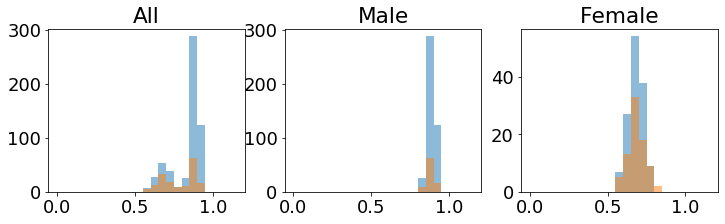

In [140]:
bins = np.arange(0, 1.2, 0.05)

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.hist(predict[test_indices & is_ihart & has_data & y & ~is_parent], bins=bins, alpha=0.5)
plt.hist(predict[test_indices & is_ihart & has_data & ~y & ~is_parent], bins=bins, alpha=0.5)
plt.title('All')

plt.subplot(1, 3, 2)
plt.hist(predict[test_indices & is_ihart & has_data & y & ~is_parent & is_male], bins=bins, alpha=0.5)
plt.hist(predict[test_indices & is_ihart & has_data & ~y & ~is_parent & is_male], bins=bins, alpha=0.5)
plt.title('Male')

plt.subplot(1, 3, 3)
plt.hist(predict[test_indices & is_ihart & has_data & y & ~is_parent & ~is_male], bins=bins, alpha=0.5)
plt.hist(predict[test_indices & is_ihart & has_data & ~y & ~is_parent & ~is_male], bins=bins, alpha=0.5)
plt.title('Female')

plt.show()

In [141]:
for i in np.argsort(np.abs(coeffs))[-40:]:
    del_index = i-2
    if del_index<X.shape[1]:
        print('%s:%d-%d HET' % all_deletions[del_index], all_deletions[del_index][2]-all_deletions[del_index][1], del_index)
        print(coeffs[i])
        print()
    else:
        del_index = np.where(has_homalt)[0][del_index-X.shape[1]]
        print('%s:%d-%d HOMALT' % all_deletions[del_index], del_index)
        print(coeffs[i])
        print()
    


10:39338560-39341453 HET 2893 17913
0.021880592653978716

13:18769380-18786965 HET 17585 5821
0.02280186584564256

18:71247034-71247052 HET 18 24547
0.023603005837510745

19:566223-569251 HET 3028 189
0.02502425436756399

11:55597995-55663999 HET 66004 21977
0.025285460762194876

9:129727-152144 HET 22417 108
0.026350017036486012

17:21920974-21981614 HET 60640 6876
0.02768546081297684

4:189270479-189278917 HET 8438 33586
0.028671611325383276

19:38102240-38102273 HET 33 17667
0.03095777948346559

16:78337862-78346420 HET 8558 25446
0.03149497054596797

21:43038616-43055844 HET 17228 19317
0.03238508469390145

10:18472224-18472232 HET 8 5563
0.032737609916197535

10:55589960-55605324 HET 15364 21972
0.037628422909985776

1:189057492-189061913 HET 4421 33583
0.03925739015167613

15:69301863-69301875 HET 12 24321
-0.0395198059207921

4:17554630-17598215 HET 43585 5150
0.04295312892425454

4:19973917-19973930 HET 13 6145
0.04870881616923585

2:34479112-34508754 HET 29642 17028
0.05002936

In [105]:
print(binom_test(np.sum(X_mat[is_ihart & has_data & ~is_parent & y, 46168]), 
                 np.sum(X[is_ihart & has_data & ~is_parent & y, 46168])))
print(binom_test(np.sum(Z_mat[is_ihart & has_data & ~is_parent & y, 46168]), 
                 np.sum(Z[is_ihart & has_data & ~is_parent & y, 46168])))
print(np.sum(X_mat[is_ihart & has_data & ~is_parent & y, 46168] + Z_mat[is_ihart & has_data & ~is_parent & y, 46168]), 
      np.sum(X_pat[is_ihart & has_data & ~is_parent & y, 46168] + Z_pat[is_ihart & has_data & ~is_parent & y, 46168]),
      binom_test(np.sum(X_mat[is_ihart & has_data & ~is_parent & y, 46168] + Z_mat[is_ihart & has_data & ~is_parent & y, 46168]), 
                 np.sum(X[is_ihart & has_data & ~is_parent & y, 46168] + Z[is_ihart & has_data & ~is_parent & y, 46168])))
print()
print(binom_test(np.sum(X_mat[is_ihart & has_data & ~is_parent & ~y, 46168]), 
                 np.sum(X[is_ihart & has_data & ~is_parent & ~y, 46168])))
print(binom_test(np.sum(Z_mat[is_ihart & has_data & ~is_parent & ~y, 46168]), 
                 np.sum(Z[is_ihart & has_data & ~is_parent & ~y, 46168])))
print(np.sum(X_mat[is_ihart & has_data & ~is_parent & ~y, 46168] + Z_mat[is_ihart & has_data & ~is_parent & ~y, 46168]), 
      np.sum(X_pat[is_ihart & has_data & ~is_parent & ~y, 46168] + Z_pat[is_ihart & has_data & ~is_parent & ~y, 46168]),
      binom_test(np.sum(X_mat[is_ihart & has_data & ~is_parent & ~y, 46168] + Z_mat[is_ihart & has_data & ~is_parent & ~y, 46168]), 
                 np.sum(X[is_ihart & has_data & ~is_parent & ~y, 46168] + Z[is_ihart & has_data & ~is_parent & ~y, 46168])))


IndexError: boolean index did not match indexed array along dimension 0; dimension is 4782 but corresponding boolean dimension is 2635

IndexError: boolean index did not match indexed array along dimension 1; dimension is 63954 but corresponding boolean dimension is 82301

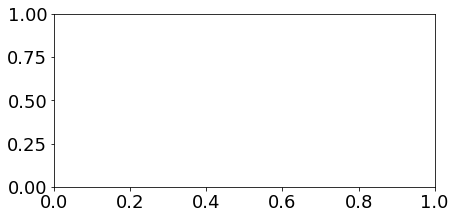

In [51]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 2, 1)
plt.scatter(np.clip(np.sum(X[has_data & is_ihart & test_indices & y, :][:, ~np.isclose(coeffs, 0) & (coeffs>0)]/np.sum(has_data & is_ihart & test_indices & y), axis=0), 0, 1), 
         np.clip(np.sum(X[has_data & is_ihart & test_indices & ~y, :][:, ~np.isclose(coeffs, 0) & (coeffs>0)]/np.sum(has_data & is_ihart & test_indices & ~y), axis=0), 0, 1), 
         alpha=0.5, label='+')
plt.scatter(np.clip(np.sum(X[has_data & is_ihart & test_indices & y, :][:, ~np.isclose(coeffs, 0) & (coeffs<0)]/np.sum(has_data & is_ihart & test_indices & y), axis=0), 0, 1), 
         np.clip(np.sum(X[has_data & is_ihart & test_indices & ~y, :][:, ~np.isclose(coeffs, 0) & (coeffs<0)]/np.sum(has_data & is_ihart & test_indices & ~y), axis=0), 0, 1), 
         alpha=0.5, label='-')
plt.xlabel('autism')
plt.ylabel('neurotypical')
plt.title('Inherited Allele Frequency')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(np.clip(np.sum(X[has_data & is_ihart & test_indices & y, :][:, ~np.isclose(coeffs, 0)], axis=1), 0, 100), 
         bins=np.arange(101), alpha=0.5, label='aut')
plt.hist(np.clip(np.sum(X[has_data & is_ihart & test_indices & ~y, :][:, ~np.isclose(coeffs, 0)], axis=1), 0, 100), 
         bins=np.arange(101), alpha=0.5, label='nt')
plt.xlabel('Inherited deletions/sample')
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(np.clip(np.sum(Z[has_data & is_ihart & test_indices & y, :][:, ~np.isclose(coeffs, 0) & (coeffs>0)]/np.sum(has_data & is_ihart & test_indices & y), axis=0), 0, 1), 
         np.clip(np.sum(Z[has_data & is_ihart & test_indices & ~y, :][:, ~np.isclose(coeffs, 0) & (coeffs>0)]/np.sum(has_data & is_ihart & test_indices & ~y), axis=0), 0, 1), 
         alpha=0.5, label='+')
plt.scatter(np.clip(np.sum(Z[has_data & is_ihart & test_indices & y, :][:, ~np.isclose(coeffs, 0) & (coeffs<0)]/np.sum(has_data & is_ihart & test_indices & y), axis=0), 0, 1), 
         np.clip(np.sum(Z[has_data & is_ihart & test_indices & ~y, :][:, ~np.isclose(coeffs, 0) & (coeffs<0)]/np.sum(has_data & is_ihart & test_indices & ~y), axis=0), 0, 1), 
         alpha=0.5, label='-')
plt.xlabel('autism')
plt.ylabel('neurotypical')
plt.title('De novo Allele Frequency')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

plt.subplot(2, 2, 4)
plt.hist(np.clip(np.sum(Z[has_data & is_ihart & test_indices & y, :][:, ~np.isclose(coeffs, 0)], axis=1), 0, 20), 
         bins=np.arange(21), alpha=0.5, label='aut')
plt.hist(np.clip(np.sum(Z[has_data & is_ihart & test_indices & ~y, :][:, ~np.isclose(coeffs, 0)], axis=1), 0, 20), 
         bins=np.arange(21), alpha=0.5, label='nt')
plt.xlabel('De novo deletions/sample')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.scatter(np.sum(X[has_data & is_ihart & test_indices, :][:, ~np.isclose(coeffs, 0)], axis=0), 
            np.sum(Z[has_data & is_ihart & test_indices, :][:, ~np.isclose(coeffs, 0)], axis=0), 
         )

plt.show()

In [ ]:
for i in np.argsort(np.abs(coeffs))[-40:]:
    print(all_deletions[i], coeffs[i])

# Try for scores

In [ ]:
# pull scores

z = np.zeros(y.shape, dtype=float)
z[:] = np.nan

value = 'ADIR2003:communication'
with open('../../PhenotypeGLRM/data/all_samples.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    identifier_index = header.index('identifier')
    value_index = header.index(value)
    
    for line in reader:
        sample_id = line[identifier_index]
        if sample_id in child_to_index:
            z[child_to_index[sample_id]] = np.nan if line[value_index] == '' else float(line[value_index])
            
#print(np.nanmean(z[y==1]), np.nanmean(z[y==0]))
#z[np.isnan(z) & (y==1)] = np.nanmean(z[y==1])
#z[np.isnan(z) & (y==0)] = 0
#z[z<10] = 0
#z[(z>=10) & (z<20)] = 1
#z[(z>=20)] = 2

In [ ]:
plt.hist(z[is_ihart & has_data & y], alpha=0.5)
plt.hist(z[~is_ihart & has_data & y], alpha=0.5)
plt.show()

In [674]:
#model = ElasticNet(alpha=0.015, l1_ratio=0.9, fit_intercept=True, normalize=True)
model = Lasso(alpha=0.1, positive=True, fit_intercept=True)
result = model.fit(np.hstack((~is_male[~test_indices & is_ihart & has_data & ~is_parent & ~np.isnan(z), np.newaxis], 
                              X[~test_indices & is_ihart & has_data & ~is_parent & ~np.isnan(z), :] +\
                              Z[~test_indices & is_ihart & has_data & ~is_parent & ~np.isnan(z), :],
)), 
                   z[~test_indices & is_ihart & has_data & ~is_parent & ~np.isnan(z)])
coeffs = result.coef_
print(np.sum(~np.isclose(coeffs, 0)))

97


In [675]:
print(is_male.shape, X.shape, Z.shape, coeffs.shape)

(6687,) (6687, 63954) (6687, 63954) (63955,)


In [676]:
predict = model.predict(np.hstack((~is_male[:, np.newaxis], X+Z)))


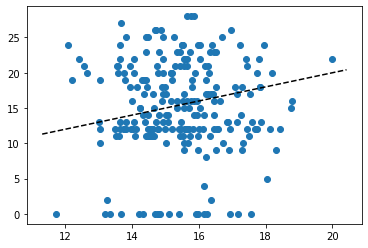

In [677]:
plt.scatter(predict[test_indices & is_ihart & has_data & ~is_parent ], z[test_indices & is_ihart & has_data & ~is_parent ])
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.show()



//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in long_scalars


0.6105902686848584


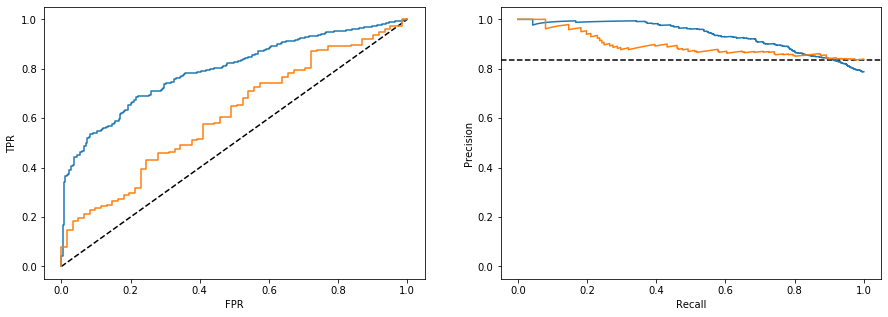

In [665]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
train_fpr, train_tpr, _ = metrics.roc_curve(y[~test_indices & ~np.isnan(z) & is_ihart & has_data & ~is_parent], 
                                            predict[~test_indices & ~np.isnan(z) & is_ihart & has_data & ~is_parent])
test_fpr, test_tpr, _ = metrics.roc_curve(y[test_indices & is_ihart & has_data & ~is_parent], 
                                          predict[test_indices & is_ihart & has_data & ~is_parent])
#test_fpr2, test_tpr2, _ = metrics.roc_curve(y[~is_ihart & has_data], predict[~is_ihart & has_data])

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.plot(train_fpr, train_tpr)
plt.plot(test_fpr, test_tpr)
#plt.plot(test_fpr2, test_tpr2)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
train_precision, train_recall, _ = metrics.precision_recall_curve(y[~test_indices & ~np.isnan(z) & is_ihart & has_data], predict[~test_indices & ~np.isnan(z) & is_ihart & has_data])
test_precision, test_recall, _ = metrics.precision_recall_curve(y[test_indices & is_ihart & has_data], predict[test_indices & is_ihart & has_data])
#test_precision2, test_recall2, _ = metrics.precision_recall_curve(y[~is_ihart & has_data], predict[~is_ihart & has_data])

plt.axhline(np.sum(y & test_indices & is_ihart & has_data)/np.sum(test_indices & is_ihart & has_data), linestyle='--', color='black')
plt.axhline(np.sum(y & ~is_ihart & has_data)/np.sum(~is_ihart & has_data), linestyle='--', color='black')
plt.plot(train_recall, train_precision)
plt.plot(test_recall, test_precision)
#plt.plot(test_recall2, test_precision2)
plt.xlabel('Recall')
plt.ylabel('Precision')

print(metrics.auc(test_fpr, test_tpr))

plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.boxplot([predict[test_indices & ~np.isnan(z) & is_ihart & has_data & (z==x)] for x in range(0, 3)])

plt.xlabel('Actual')
plt.ylabel('Predicted')

print(pearsonr(z[~test_indices & ~np.isnan(z) & (z>0) & is_ihart & has_data], predict[~test_indices & ~np.isnan(z) & (z>0) & is_ihart & has_data]))
print(pearsonr(z[test_indices & ~np.isnan(z) & (z>0) & is_ihart & has_data], predict[test_indices & ~np.isnan(z) & (z>0) & is_ihart & has_data]))

ax = plt.subplot(1, 2, 2)
plt.boxplot([predict[~is_ihart & has_data & ~np.isnan(z) & (z==x)] for x in range(0, 3)])

plt.xlabel('Actual')
plt.ylabel('Predicted')

print(pearsonr(z[~is_ihart & has_data & ~np.isnan(z) & (z>0)], predict[~is_ihart & has_data & ~np.isnan(z) & (z>0)]))

#plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
#train_precision, train_recall, _ = metrics.precision_recall_curve(y[~test_indices], predict[~test_indices, 1])
#test_precision, test_recall, _ = metrics.precision_recall_curve(y[test_indices], predict[test_indices, 1])
#
#plt.axhline(np.sum(y/y.shape[0]), linestyle='--', color='black')
#plt.plot(train_recall, train_precision)
#plt.plot(test_recall, test_precision)
#plt.xlabel('Recall')
#plt.ylabel('Precision')

#print(metrics.auc(test_fpr, test_tpr))
plt.show()

In [ ]:
n = X.shape[1]
beta = cp.Variable(n)
lambd = 0.9
log_likelihood = cp.sum(
    cp.multiply(y, X @ beta) - cp.logistic(X @ beta)
)
problem = cp.Problem(cp.Maximize(log_likelihood/n - lambd * cp.norm(beta[5:], 1) - lambd * cp.norm(beta[5:], 2)), [])
problem.solve()

In [ ]:
print(np.sum(~np.isclose(beta.value, 0)))

In [ ]:
for i in np.argsort(np.abs(coeffs.flatten()))[-20:]:
    print(deletions[i], coeffs[0, i])

In [ ]:
for i in np.argsort(np.abs(coeffs.flatten()))[-20:]:
    print(deletions[i], coeffs[0, i])

In [ ]:
model = Logit(y, X[:, ~np.isclose(coeffs, 0).flatten()])
result = model.fit()
print(result.summary())

In [ ]:
0.655

# Try sibpairs